The following code prepares a set of 200,000 randomly generated samples across Germnay

In [1]:
import ee
import geemap


In [2]:
ee.Authenticate()
ee.Initialize()
Map = geemap.Map()


Successfully saved authorization token.


In [3]:
import os
import math
import json
import requests
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON
from utils.ee_utils import *
from utils.plot_utils import TextColors as c

In [4]:
# BoundingBox for Germany
geo = ee.Geometry.BBox(5.98865807458, 47.3024876979, 15.0169958839, 54.983104153) # ee.Geometry.BBox(4.713226,47.122056,15.347425,55.119174)

In [5]:
SIMCLR_CSV_PATH = "random_samples/"
# check if the folder exists, if not create it
if not os.path.exists(SIMCLR_CSV_PATH):
    os.makedirs(SIMCLR_CSV_PATH)
    
NUM_POINTS = 1000 # should be 1000 for Nafiseh
NUM_CSV_FILES = 200 # must be 100 for Nafiseh

for i in range(NUM_CSV_FILES):
    df = random_point_csv_generator(geo, num_points= NUM_POINTS,
                                    file_name=SIMCLR_CSV_PATH + "random_points_" + str(i),
                                    start_id=10000000 + i*NUM_POINTS, seed=i)
    print(f"{c.OKGREEN}Successfully generated {SIMCLR_CSV_PATH + 'random_points_' + str(i)}.csv file.{c.ENDC}") 

Successfully generated random_samples/random_points_0.csv file.
Successfully generated random_samples/random_points_1.csv file.
Successfully generated random_samples/random_points_2.csv file.
Successfully generated random_samples/random_points_3.csv file.
Successfully generated random_samples/random_points_4.csv file.
Successfully generated random_samples/random_points_5.csv file.
Successfully generated random_samples/random_points_6.csv file.
Successfully generated random_samples/random_points_7.csv file.
Successfully generated random_samples/random_points_8.csv file.
Successfully generated random_samples/random_points_9.csv file.
Successfully generated random_samples/random_points_10.csv file.
Successfully generated random_samples/random_points_11.csv file.
Successfully generated random_samples/random_points_12.csv file.
Successfully generated random_samples/random_points_13.csv file.
Successfully generated random_samples/random_points_14.csv file.
Successfully generated random_sampl

In [6]:
random_point = df.sample(n=1)

In [7]:
lat = random_point['lat'].values[0]
lon = random_point['long'].values[0]
roi = get_square_roi(lat,lon, roi_size=10000, return_gee_object=True)
Map.addLayer(geo, {}, 'Europe')
Map.addLayer(roi, {}, 'ROI')
Map.centerObject(roi, 10)
land_cover = ee.ImageCollection('ESA/WorldCover/v100').first().clip(roi)
vis = {'bands': ['Map']}
Map.addLayer(land_cover, vis, 'Land Cover')
Map

Map(center=[54.68509109828989, 14.929775189903202], controls=(WidgetControl(options=['position', 'transparent_…

| Value | Description |
|---|---|
| 10  | Tree cover |
| 20  | Shrubland |
| 30  | Grassland |
| 40 | Cropland |
| 50 |  Built-up |
| 60 |  Bare / sparse vegetation |
| 70 |  Snow and ice |
| 80 | Permanent water bodies |
| 90 |  Herbaceous wetland |
| 95 |  Mangroves |
| 100 |  Moss and lichen |

In [8]:
# read csv files in SIMCLR_CSV_PATH as a pandas dataframe
# took 1415 min to run for 200,000 samples 
csv_files = [SIMCLR_CSV_PATH + file for file in os.listdir(SIMCLR_CSV_PATH) if file.endswith('.csv')]

for file in csv_files:
    df = pd.read_csv(file)
    print(f"{c.OKGREEN}Successfully read {file}.{c.ENDC}")
    df['unwanted_cover_percentage'] = 0
    total_rows = len(df)
    for index, row in df.iterrows():
        lat = row['lat']
        lon = row['long']
        roi = get_square_roi(lat, lon, roi_size=1920, return_gee_object=True)
        land_cover = ee.ImageCollection('ESA/WorldCover/v100').first().clip(roi)
        percentage = calculate_land_cover_percentage(land_cover, [80, 50, 95], roi=roi, scale=30).getInfo()
        df.at[index, 'unwanted_cover_percentage'] = percentage
        print(f"Progress: {index + 1}/{total_rows}", end='\r')  # Print progress without tqdm
        # save the dataframe to the same csv file
    df.to_csv(file, index=True, index_label='OID_')


Successfully read random_samples/random_points_0.csv.
Successfully read random_samples/random_points_1.csv.
Successfully read random_samples/random_points_10.csv.
Successfully read random_samples/random_points_100.csv.
Successfully read random_samples/random_points_101.csv.
Successfully read random_samples/random_points_102.csv.
Successfully read random_samples/random_points_103.csv.
Successfully read random_samples/random_points_104.csv.
Successfully read random_samples/random_points_105.csv.
Successfully read random_samples/random_points_106.csv.
Successfully read random_samples/random_points_107.csv.
Successfully read random_samples/random_points_108.csv.
Successfully read random_samples/random_points_109.csv.
Successfully read random_samples/random_points_11.csv.
Successfully read random_samples/random_points_110.csv.
Successfully read random_samples/random_points_111.csv.
Successfully read random_samples/random_points_112.csv.
Successfully read random_samples/random_points_113.csv

In [ ]:
path = 'C:\\Users\\...\\random_samples'

# create an empty list to store the dataframes
dfs = []

# loop through all the files in the directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        # read the csv file into a dataframe
        df = pd.read_csv(os.path.join(path, file))
        # append the dataframe to the list
        dfs.append(df)

# concatenate the dataframes into a single dataframe
result = pd.concat(dfs, axis=0, ignore_index=True)

# save as csv
result.to_csv('random_samples_large.csv', index=False)

<AxesSubplot:>

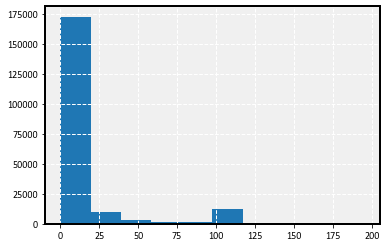

In [10]:
result['unwanted_cover_percentage'].hist()

In [11]:
result.drop('OID_.1', axis=1, inplace=True)

In [12]:
result.head()

,OID_,Point_ID,long,lat,OC,unwanted_cover_percentage
0,0,10000000,12.173777,50.298560,0.0,4.140052
1,1,10000001,14.426816,47.541121,0.0,0.000000
2,2,10000002,6.939105,48.864015,0.0,11.959331
3,3,10000003,11.126565,48.040253,0.0,69.612229
4,4,10000004,7.206032,54.347616,0.0,0.000000


In [13]:
result = result[result['unwanted_cover_percentage'] <= 20]
result.count()

OID_                         173114
Point_ID                     173114
long                         173114
lat                          173114
OC                           173114
unwanted_cover_percentage    173114
dtype: int64

In [14]:
# Rename column 'A' to 'X'
result = result.rename(columns={'long': 'X', 'lat':'Y'})

In [15]:
result

,OID_,Point_ID,X,Y,OC,unwanted_cover_percentage
0,0,10000000,12.173777,50.298560,0.0,4.140052
1,1,10000001,14.426816,47.541121,0.0,0.000000
2,2,10000002,6.939105,48.864015,0.0,11.959331
4,4,10000004,7.206032,54.347616,0.0,0.000000
6,6,10000006,10.421609,52.467332,0.0,0.240385
...,...,...,...,...,...,...
199995,995,10099995,13.067161,51.535751,0.0,5.121776
199996,996,10099996,7.500949,51.569918,0.0,12.382270
199997,997,10099997,8.056123,51.044345,0.0,1.210566
199998,998,10099998,7.577162,51.539747,0.0,6.947688


In [16]:
result.to_csv('Random_samples_large.csv', index=False)